In [1]:
import numpy as np
import matplotlib.pyplot as plt

from zero_form import ZeroForm
from one_form import OneForm
from poisson_solver import poisson_solve

In [2]:
L = 1.0
N = 2 ** 6
h = (L / N)

# Create the array of vertices, xyz indexing.
V_ind = np.asarray([[[[i,j,k] for k in range(N)] for j in range(N)] for i in range(N)])
V = V_ind * h
V.shape

(64, 64, 64, 3)

# 1-form class

This is the class we use to represent our 1-forms.  

More precicely, as in the paper, we discretize our 1-form $\eta$ as the symmetric average value between two neighbouring grid points.  


More formally, we approximate the 1-form as a $|V| \times 3$ matrix $\mathbf{X}$, where

$$
\mathbf{X}_{\mathcal{v}, i} = \frac{1}{2h} \int_{\mathcal{v} - h\mathbf{e}_i}^{\mathcal{v} + h\mathbf{e}_i} \eta
$$



In [3]:
def evaluate(pos):
    response = np.zeros_like(pos)
    response[:, :, :, 0] = -pos[:, :, :, 1] * np.sin(2 * np.pi * pos[:, :, :, 0])
    response[:, :, :, 1] = pos[:, :, :, 0]
    return response

def evaluate2(pos):
    res = np.zeros_like(pos)
    res[:, :, :, 0] = pos[:, :, :, 0] ** 2
    return res

form = OneForm(V_ind[:], evaluation=evaluate)
form2 = OneForm(V_ind[:], evaluation=evaluate2)

print(form.mass)
print((form * form2))
print(form.l2_norm)

0.6352661347645238
0.07827114626307333
0.6988149148066676


In [4]:
def evaluate_zero_form(pos):
    x = pos[..., 0]
    y = pos[..., 1]
    z = pos[..., 2]
    return np.abs(np.sin(x * 2 * np.pi)) ** (0.1)

In [5]:
zero_form = ZeroForm(V_ind[:], evaluation=evaluate_zero_form)
zero_form.h

0.015625

In [6]:
df = zero_form.differentiation()
df.shape

(64, 64, 64, 3)

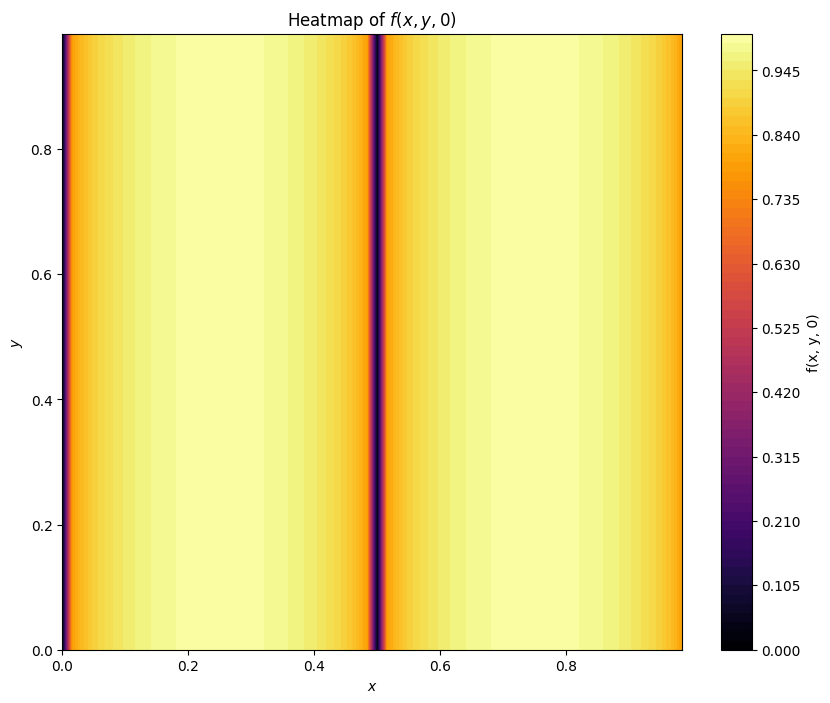

In [7]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], zero_form.scalar_field[:, :, 0], levels=80, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [8]:
df.shape

(64, 64, 64, 3)

In [9]:
zero_form.scalar_field.max()

np.float64(1.0)

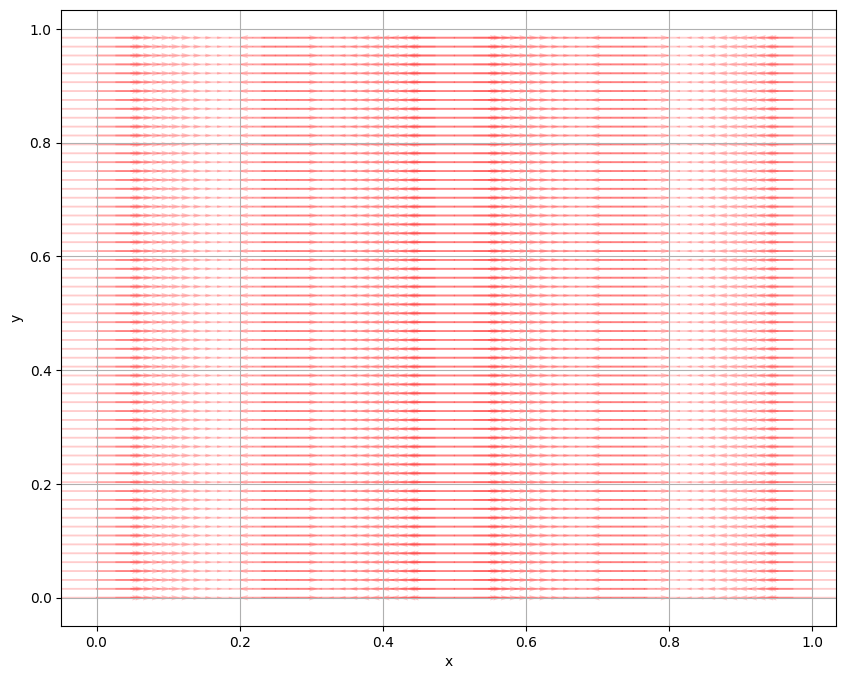

In [10]:
# Plot the scalar field and gradient

plt.figure(figsize=(10, 8))
plt.quiver(V[:, :, 0, 0], V[:, :, 0, 1], df[:, :, 0, 0] * 0.01, df[:, :, 0, 1] * 0.01, color='red', scale=0.5, pivot='middle', alpha=0.2)

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

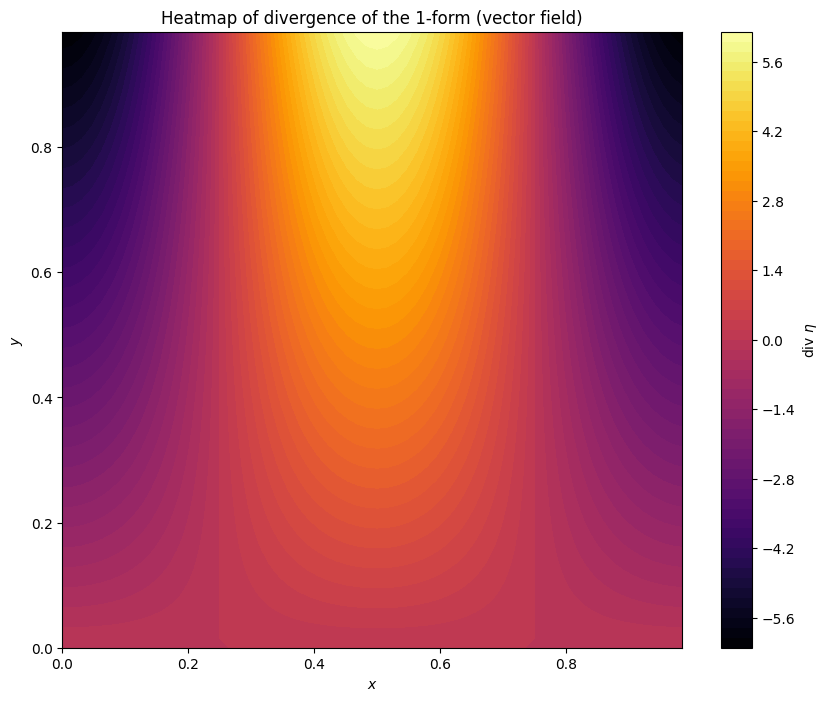

In [11]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], form.divergence()[:, :, 0], levels=80, cmap='inferno')
plt.colorbar(label='div $\eta$')
plt.title('Heatmap of divergence of the 1-form (vector field)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [12]:
result = poisson_solve(zero_form)
result.shape

(64, 64, 64)

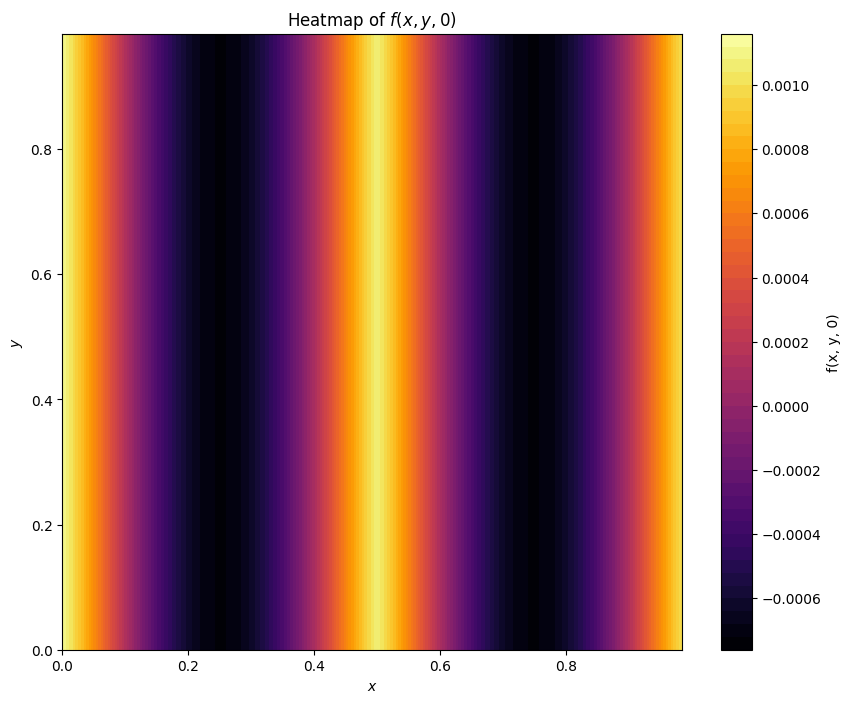

In [13]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], result[:, :, 0].real, levels=60, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

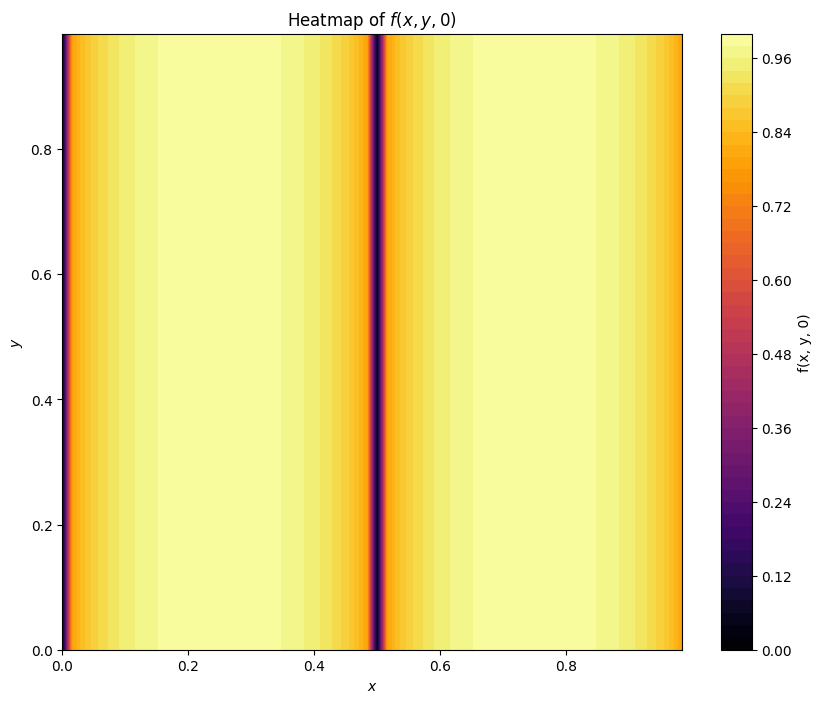

In [14]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], zero_form.scalar_field[:, :, 0], levels=60, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

/home/tuomas/Coding/Minimal_surface/zero_form.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[..., 0] = (np.roll(phi, -1, axis=0) - np.roll(phi, 1, axis=0)) / (2 * self.h)  # x-direction
/home/tuomas/Coding/Minimal_surface/zero_form.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[..., 1] = (np.roll(phi, -1, axis=1) - np.roll(phi, 1, axis=1)) / (2 * self.h)  # y-direction
/home/tuomas/Coding/Minimal_surface/zero_form.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  grad[..., 2] = (np.roll(phi, -1, axis=2) - np.roll(phi, 1, axis=2)) / (2 * self.h)  # z-direction


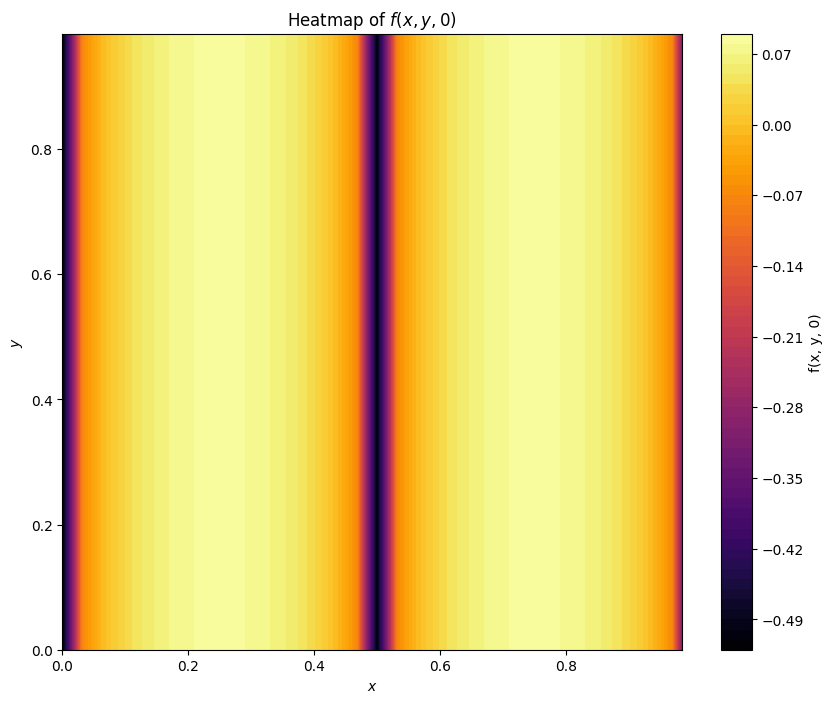

In [15]:
twice_differentiated = OneForm(V_ind[:], vector_field=ZeroForm(V_ind[:], scalar_field=result).differentiation()).divergence()
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], twice_differentiated[:, :, 0], levels=60, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [16]:
def algorithm_1(lambda_hat: np.array, X_0: np.array, X_hat: np.array, tau: float = 0.1) -> np.array:
    assert tau > 0, "hyperparameter tau should be positive."

    Y = X_hat - X_0 - (1 / tau) * lambda_hat
    Y_vectorfield = OneForm(V_ind, vector_field=Y)

    # D^T Y and then solve the poisson equation
    D_Y = Y_vectorfield.divergence()
    D_Y_form = ZeroForm(V_ind, scalar_field=D_Y)
    phi = poisson_solve(D_Y_form)
    return phi

In [17]:
def algorithm_2(lambda_hat: np.array, X_0: np.array, d_phi: np.array, tau: float = 0.1):
    Z = tau * lambda_hat + d_phi + X_0
    Z_form = OneForm(V_ind[:], vector_field=Z)
    Z_norm = Z_form.vertex_norms()
    if_mask = Z_norm * tau > 1  # Boolean mask for if section

    X = np.zeros_like(Z)
    X[if_mask] = (1 - (1 / (tau * Z_norm[if_mask])))[:, np.newaxis] * Z[if_mask]
    return X

In [18]:
def solve_plateau(V, X_0, tau=0.6, rho=0.8, max_iter=50):
    """
    Implements the ADMM-based solver for the minimal surface problem.

    Parameters:
        X0: Initial guess for the vector field.
        tau: Step size.
        rho: Acceleration threshold.
        max_iter: Number of iterations.

    Returns:
        X: The optimized vector field representing the minimal surface.
    """
    X = X_0.copy()
    X_hat = X_0.copy()
    lambda_ = np.zeros_like(X_0)
    lambda_hat = np.zeros_like(X_0)
    alpha = 1
    c_prev = np.inf

    lambda_prev = lambda_[:]
    X_prev = X[:]


    for k in range(max_iter):
        if k > 0:
            X_prev = X.copy()
            lambda_prev = lambda_.copy()
            c_prev = c

        # Solve for φ using the Poisson solver
        phi = algorithm_1(lambda_hat=lambda_hat, X_0=X_0, tau = tau, X_hat=X_hat)
        phi_form = ZeroForm(V, scalar_field=phi)
        d_phi = phi_form.differentiation()

        # Solve for X using shrinkage
        X = algorithm_2(lambda_hat=lambda_hat, X_0 = X_0, d_phi=d_phi, tau=tau)
        X_form = OneForm(V, vector_field=X)

        error = d_phi - X + X_0
        error_form = OneForm(V, vector_field=error)

        # Update lambda
        lambda_ = lambda_hat + tau * (error)

        # Compute convergence criteria
        c = (1 / tau) * np.linalg.norm(lambda_ - lambda_hat) ** 2 + tau * np.linalg.norm(X - X_hat) ** 2

        print(f"Mass of X: {X_form.mass}")
        print(f"Error mass: {error_form.mass}")
        print(f"convergence criteria: {c}")
        print(f"Dphi: {np.linalg.norm(d_phi, axis = -1).max()}")
        print(f"X - X_0: {np.linalg.norm(X - X_hat).max()}")

        if k == 0:
            lambda_hat = lambda_
            X_hat = X
            alpha = 1

        # Acceleration update
        if c < rho * c_prev:
            alpha_new = (1 + np.sqrt(1 + 4 * alpha ** 2)) / 2
            lambda_hat = lambda_ + (alpha - 1) / alpha_new * (lambda_ - lambda_prev)
            X_hat = X + (alpha - 1) / alpha_new * (X - X_prev)
            alpha = alpha_new
        else:
            lambda_hat = lambda_
            X_hat = X
            alpha = 1
            c = c_prev / rho

    return X

In [19]:
X_0 = np.random.rand(*V_ind.shape) * 1
V_mesh = V_ind[:]
X_opt = solve_plateau(V_mesh, X_0=X_0, max_iter=50)

Mass of X: 3.4500466184383543e-06
Error mass: 0.9607939784343702
convergence criteria: 314734.4648101779
Dphi: 0.0
X - X_0: 512.1315462604781
Mass of X: 0.017222427143610334
Error mass: 0.9223844631594497
convergence criteria: 142009.51698977491
Dphi: 0.6211238992803174
X - X_0: 32.06294986352492
Mass of X: 0.1946694161452222
Error mass: 0.7404363207927382
convergence criteria: 99648.64053963048
Dphi: 0.5775779547812345
X - X_0: 136.12833490808316
Mass of X: 0.5112185681280519
Error mass: 0.4216755580061695
convergence criteria: 43538.96572009174
Dphi: 0.6374176381696804
X - X_0: 146.072879970818
Mass of X: 0.7856591600053208
Error mass: 0.1572245052646805
convergence criteria: 10390.19127588993
Dphi: 0.7242056699727563
X - X_0: 80.73675744979164
Mass of X: 0.9506552496336512
Error mass: 0.09344843589371778
convergence criteria: 3236.5363441540594
Dphi: 0.6950085853129626
X - X_0: 45.51655730557299
Mass of X: 1.015198933026571
Error mass: 0.10929599711395435
convergence criteria: 2855.